In [1]:
# import relevant packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from acquire import get_crime_data
from datetime import datetime
import prepare

In [70]:
# plotting defaults
plt.rc('figure', figsize=(23, 10))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [2]:
df = get_crime_data(use_cache = False)

Acquiring data from api


In [3]:
df = prepare.prep_data(df)

In [4]:
#Assign my .shp file to a variable named “asutin_map”
austin_map = gpd.read_file('Boundaries_zipcode/geo_export_9b5aa23d-57b1-41f4-b4f9-0a9d97fac540.shp')

In [5]:
austin_map = austin_map.drop(columns =['affgeoid10','geoid10','aland10','awater10'])

In [6]:
austin_map = austin_map.rename(columns ={'zcta5ce10': 'zip_code'})

In [7]:
#create a new dataframe with both our geographical and statistical data in it by merging our two tables together.
new_df = austin_map.merge(df, on ='zip_code')

In [8]:
new_df.to_csv('Geo_Crime_Reports.csv')

In [9]:
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 349574 entries, 0 to 349573
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   zip_code          349574 non-null  object        
 1   geometry          349574 non-null  geometry      
 2   crime_type        349574 non-null  object        
 3   family_violence   349574 non-null  object        
 4   occurrence_time   349574 non-null  datetime64[ns]
 5   occurrence_date   349574 non-null  datetime64[ns]
 6   report_time       349574 non-null  datetime64[ns]
 7   report_date       349574 non-null  datetime64[ns]
 8   location_type     349574 non-null  object        
 9   address           349574 non-null  object        
 10  council_district  349574 non-null  object        
 11  sector            349574 non-null  object        
 12  district          349574 non-null  object        
 13  latitude          349574 non-null  float64       
 

In [10]:
new_df.head()

,zip_code,geometry,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared
0,78745,"POLYGON ((-97.84494 30.20041, -97.83965 30.199...",BURGLARY OF VEHICLE,N,2021-12-31 22:28:00,2021-12-31,2021-12-31 22:28:00,2021-12-31,PARKING /DROP LOT/ GARAGE,901 LITTLE TEXAS LN,2,FR,4,30.198187,-97.769155,not cleared,2022-01-03,False
1,78745,"POLYGON ((-97.84494 30.20041, -97.83965 30.199...",ASSAULT BY CONTACT FAM/DATING,Y,2021-12-31 18:56:00,2021-12-31,2021-12-31 18:56:00,2021-12-31,RESIDENCE / HOME,4320 S CONGRESS AVE,3,DA,3,30.219033,-97.767189,not cleared,2022-01-03,False
2,78745,"POLYGON ((-97.84494 30.20041, -97.83965 30.199...",BURGLARY OF SHED/DETACHED GARAGE/STORAGE UNIT,N,2021-12-31 18:00:00,2021-12-31,2022-01-10 14:57:00,2022-01-10,COMMERCIAL / OFFICE BUILDING,4501 TERRY O LN,3,DA,3,30.213162,-97.760094,not cleared,2022-01-12,False
3,78745,"POLYGON ((-97.84494 30.20041, -97.83965 30.199...",BURGLARY OF VEH-NO SUSPECT/FU,N,2021-12-31 18:00:00,2021-12-31,2022-01-07 10:19:00,2022-01-07,RESIDENCE / HOME,7001 COOPER LN,2,FR,3,30.195661,-97.792699,not cleared,2022-01-10,False
4,78745,"POLYGON ((-97.84494 30.20041, -97.83965 30.199...",FAMILY DISTURBANCE,N,2021-12-31 15:55:00,2021-12-31,2021-12-31 16:33:00,2021-12-31,OTHER / UNKNOWN,E WILLIAM CANNON DR / S CONGRESS AVE,2,FR,3,30.193012,-97.778879,not cleared,2022-01-26,False


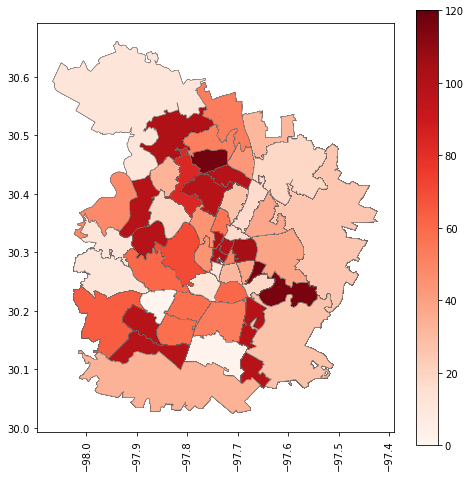

In [11]:
#Crime_type by zip_code
fig, ax = plt.subplots(1, figsize=(8, 8))
plt.xticks(rotation=90)
new_df.plot(column="crime_type", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
bar_info._A = []
cbar = fig.colorbar(bar_info)

# We predict that there is a relationship between higher seasonal levels of crime and clearance status.

In [12]:
train, validate, test = prepare.split_data(new_df)

In [13]:
df = train.copy()

In [14]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 195761 entries, 22247 to 192084
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   zip_code          195761 non-null  object        
 1   geometry          195761 non-null  geometry      
 2   crime_type        195761 non-null  object        
 3   family_violence   195761 non-null  object        
 4   occurrence_time   195761 non-null  datetime64[ns]
 5   occurrence_date   195761 non-null  datetime64[ns]
 6   report_time       195761 non-null  datetime64[ns]
 7   report_date       195761 non-null  datetime64[ns]
 8   location_type     195761 non-null  object        
 9   address           195761 non-null  object        
 10  council_district  195761 non-null  object        
 11  sector            195761 non-null  object        
 12  district          195761 non-null  object        
 13  latitude          195761 non-null  float64     

In [15]:
df['occurrence_date']= pd.to_datetime(df['occurrence_date'])
df = df.set_index('occurrence_date').sort_index()

In [16]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 195761 entries, 2018-01-01 to 2021-12-31
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   zip_code          195761 non-null  object        
 1   geometry          195761 non-null  geometry      
 2   crime_type        195761 non-null  object        
 3   family_violence   195761 non-null  object        
 4   occurrence_time   195761 non-null  datetime64[ns]
 5   report_time       195761 non-null  datetime64[ns]
 6   report_date       195761 non-null  datetime64[ns]
 7   location_type     195761 non-null  object        
 8   address           195761 non-null  object        
 9   council_district  195761 non-null  object        
 10  sector            195761 non-null  object        
 11  district          195761 non-null  object        
 12  latitude          195761 non-null  float64       
 13  longitude         195761 non-null  

In [17]:
#Split by month first
df['month'] = df.index.month_name()

In [54]:
y = df['crime_type']

In [55]:
y

occurrence_date
2018-01-01                          THEFT
2018-01-01                            DWI
2018-01-01    CUSTODY ARREST TRAFFIC WARR
2018-01-01              THEFT FROM PERSON
2018-01-01                    AGG ASSAULT
                         ...             
2021-12-31     RESISTING ARREST OR SEARCH
2021-12-31            ASSAULT WITH INJURY
2021-12-31             FAMILY DISTURBANCE
2021-12-31             ASSAULT BY CONTACT
2021-12-31     RESISTING ARREST OR SEARCH
Name: crime_type, Length: 195761, dtype: object

In [57]:
#y2 = y.groupby(y.index.month).mean()

In [68]:
df["crime_type"].value_counts().head(5)

BURGLARY OF VEHICLE    19510
THEFT                  16928
FAMILY DISTURBANCE     13634
CRIMINAL MISCHIEF      10854
AUTO THEFT              7199
Name: crime_type, dtype: int64

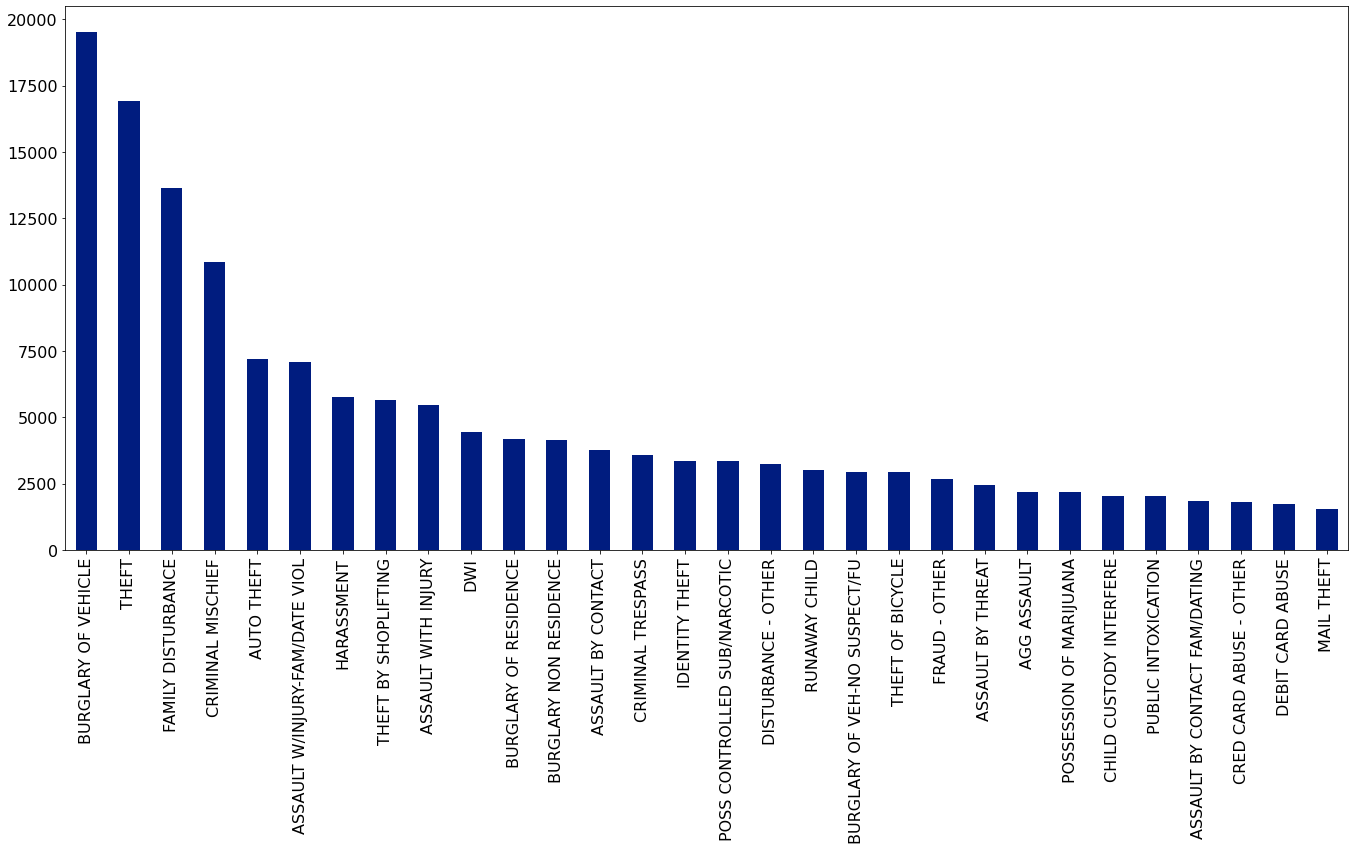

In [77]:
ax = df["crime_type"].value_counts().head(30).plot(kind='bar')
plt.show()

In [39]:
#What our average sales look like for each month?
df['month'] = pd.Categorical(df['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                                                            'September','October', 'November', 'December'])
#overall_mean = df.groupby('month').crime_type.value_counts()
y.plot.bar()
plt.title("Average by Month")
plt.xlabel("Crime")
plt.ylabel("Y")
plt.tick_params('x', rotation=65)
#plt.axhline(overall_mean,color="r")
None

ValueError: Image size of 784388x1682348 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [ ]:
#Better graph
num_crime = df.crime_type.value_counts()
for c in df.crime_type.unique():
    sample = num_crime == c
    sample.resample('M').plot(label=c)
    plt.legend()